<a href="https://colab.research.google.com/github/Ali-Kazmi/All-Pairs-Shortest-Path/blob/master/APSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I will use python's networkX library to perform All Pairs Shortest Paths (APSP) on the california road dataset. 

The cell below installs the files we need. 

In [0]:
!if ! test -f ca-roads.zip ; then wget https://github.com/rvuduc/graph-demos-for-ali/raw/master/sssp-networkx/ca-roads.zip ; fi
!if ! test -d ca-roads ; then unzip ca-roads.zip && ls -al | grep ca-roads* ; fi
!if ! test -f ca-roads-path-demo.png ; then wget https://raw.githubusercontent.com/rvuduc/graph-demos-for-ali/master/sssp-networkx/ca-roads-path-demo.png ; fi
!if ! test -f problem_utils.py ; then wget https://github.com/rvuduc/graph-demos-for-ali/raw/master/sssp-networkx/problem_utils.py ; fi

--2020-05-14 03:29:19--  https://github.com/rvuduc/graph-demos-for-ali/raw/master/sssp-networkx/problem_utils.py
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rvuduc/graph-demos-for-ali/master/sssp-networkx/problem_utils.py [following]
--2020-05-14 03:29:19--  https://raw.githubusercontent.com/rvuduc/graph-demos-for-ali/master/sssp-networkx/problem_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3273 (3.2K) [text/plain]
Saving to: ‘problem_utils.py’

problem_utils.py    100%[===================>]   3.20K  --.-KB/s    in 0s      

2020-05-14 03:29:19 (56.5 MB/s) - ‘problem_utils.py’ saved [

The cell below will output an example of one shortest path (between two vertices). For APSP, we will be finding these shortest paths for all shortest paths between all pairs of vertices. As you can imagine, it gets expensive fast 

Example of what you will produce in this problem (shortest paths on the California road network):


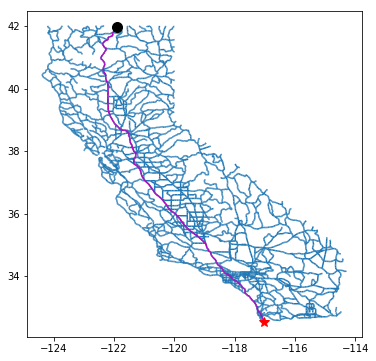

In [0]:
from problem_utils import get_path, display_image, assert_tibbles_are_equivalent, pandas_df_to_markdown_table
print("Example of what you will produce in this problem (shortest paths on the California road network):")
display_image(get_path('ca-roads-path-demo.png'))

Below we'll get the data using sql and store it into a pandas dataframe.  

In [24]:
import sys

import sqlite3 as db
import pandas as pd

print(f"* Python version:\n{sys.version}\n")
print(f"* sqlite3 version: {db.version}")
print(f"* pandas version: {pd.__version__}")

conn = db.connect('file:' + get_path('ca-roads/network.db') + '?mode=ro', uri=True)
df_intersections = pd.read_sql_query("SELECT * FROM Intersections", conn)

i_first = 0
i_last = -1
display(df_intersections.iloc[[i_first, i_last]])

* Python version:
3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]

* sqlite3 version: 2.6.0
* pandas version: 1.0.3


,ID,X,Y
0,0,-121.904167,41.974556
21047,21047,-117.035332,32.541302


In [25]:
# Define a variable named `query_roads`:
### BEGIN SOLUTION
query_roads = """
SELECT R.ID AS E,
       IA.ID AS A, IA.X AS AX, IA.Y AS AY,
       IB.ID AS B, IB.X AS BX, IB.Y AS BY
    FROM Roads AS R, Intersections AS IA, Intersections AS IB
    WHERE A=AID AND B=BID
"""
### END SOLUTION

# Demo of your query:
df_roads = pd.read_sql_query(query_roads, conn)
df_roads.head()


,E,A,AX,AY,B,BX,BY
0,0,0,-121.904167,41.974556,1,-121.902153,41.974766
1,1,0,-121.904167,41.974556,6,-121.910088,41.973942
2,2,1,-121.902153,41.974766,2,-121.896790,41.988075
3,3,2,-121.896790,41.988075,3,-121.889603,41.998032
4,4,3,-121.889603,41.998032,4,-121.886681,42.008739


In [0]:

conn.close() # Close the SQL database for good measure

And the Edgelist

In [27]:
df_distances = pd.read_csv(get_path("ca-roads/ex1_soln.csv"))
display(df_distances.head())
print("...")

,E,L
0,0,0.002025
1,1,0.005953
2,2,0.014349
3,3,0.012280
4,4,0.011099


...


In [28]:
df_edges = df_roads.merge(df_distances, on="E")
df_edges.head()

,E,A,AX,AY,B,BX,BY,L
0,0,0,-121.904167,41.974556,1,-121.902153,41.974766,0.002025
1,1,0,-121.904167,41.974556,6,-121.910088,41.973942,0.005953
2,2,1,-121.902153,41.974766,2,-121.896790,41.988075,0.014349
3,3,2,-121.896790,41.988075,3,-121.889603,41.998032,0.012280
4,4,3,-121.889603,41.998032,4,-121.886681,42.008739,0.011099


In [29]:
def get_edgelist(df):
    ### BEGIN SOLUTION
    return [(a, b, {'w': w}) for a, b, w in zip(df["A"], df["B"], df["L"])]
    ### END SOLUTION
    
# Demo
edgelist = get_edgelist(df_edges)
edgelist[:5]

[(0, 1, {'w': 0.0020249187638055285}),
 (0, 6, {'w': 0.005952750372727481}),
 (1, 2, {'w': 0.014348911108513331}),
 (2, 3, {'w': 0.012279854152229423}),
 (3, 4, {'w': 0.011098555446539574})]

In [30]:
from networkx import Graph
G = Graph()
G.add_nodes_from(df_intersections["ID"])
G.add_edges_from(edgelist)

print(f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

The graph has 21048 nodes and 21693 edges.


In [34]:
def get_shortest_path(s, t, G):
    from networkx import all_shortest_paths
    return all_shortest_paths(G, source=s, target=t, weight='w')

start = df_intersections["ID"].iloc[i_first]
finish = df_intersections["ID"].iloc[i_last]
print(f"Calculating a shortest path between nodes (intersections) {start} and {finish}...")
path = get_shortest_path(start, finish, G)

print(f"\n==> First ten nodes (intersections) along the path, which is of type `{type(path)}`:")
print('    ' + ', '.join([str(s) for s in path[:10]]) + ", ...")

Calculating a shortest path between nodes (intersections) 0 and 21047...

==> First ten nodes (intersections) along the path, which is of type `<class 'generator'>`:


TypeError: ignored